Retrieves images from "full_imgs" and stores each VOI separately in "train_imgs". Retrieves spreadsheet listing VOIs and stores them in text file. Requires data-retrieval to be run first.

In [1]:
import helper_fxns as hf
import transforms as tr
import importlib
import numpy as np
import os
import requests
import sys
import copy
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [26]:
with open("train_list.txt", "r") as f:
    vois = [x.split(',') for x in f.read().split("\n")]

voi_df = pd.DataFrame(vois, columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls"]).dropna()
voi_df = voi_df.astype({"x1": int, "x2": int, "y1": int, "y2": int, "z1": int, "z2": int})

voi_df['dx'] = voi_df.apply(lambda row: row['x2'] - row['x1'], axis=1)
voi_df['dy'] = voi_df.apply(lambda row: row['y2'] - row['y1'], axis=1)
voi_df['dz'] = voi_df.apply(lambda row: row['z2'] - row['z1'], axis=1)

In [153]:
final_size = [24,24,12]

voi_df = pd.read_csv('vois.csv')

In [168]:
def extract_voi(img, voi, final_size, aug=False):
    """Input: image, a voi from the image (as pd.Series), target size in voxels, and whether to augment.
    Outputs list of images (np.ndarray) and list of classes (string)
    """
    voi_imgs = []
    classes = []
    
    if aug:
        crop_size = [math.ceil(x*math.sqrt(2)) for x in final_size]
    else:
        crop_size = final_size
    
    exceed_ratio = max(voi['dx']/final_size[0], voi['dy']/final_size[1], voi['dz']/final_size[2],1)

    xpad = max(crop_size[0]*exceed_ratio - voi['dx'],0)
    ypad = max(crop_size[1]*exceed_ratio - voi['dy'],0)
    zpad = max(crop_size[2]*exceed_ratio - voi['dz'],0)

    """plt.subplot(121)
    plt.imshow(np.transpose(img[voi['x1']:voi['x2'],
                                voi['y2']:voi['y1']:-1,
                                (voi['z1']+voi['z2'])//2, 0], (1,0)), cmap='gray')"""

    side_padding = math.ceil(max(xpad, ypad, zpad) / 2)
    pad_img = []

    for ch in range(img.shape[-1]):
        pad_img.append(np.pad(img[:,:,:,ch], side_padding, 'constant'))

    pad_img = np.stack(pad_img, axis=3)

    voi['x1'] += side_padding - math.ceil(xpad/2)
    voi['x2'] += side_padding + math.floor(xpad/2)
    voi['y1'] += side_padding - math.ceil(ypad/2)
    voi['y2'] += side_padding + math.floor(ypad/2)
    voi['z1'] += side_padding - math.ceil(zpad/2)
    voi['z2'] += side_padding + math.floor(zpad/2)

    if exceed_ratio > 1:
        pad_img = tr.scale3d(pad_img, [1/exceed_ratio]*3)
        voi['x1'] = round(voi['x1'] / exceed_ratio)
        voi['x2'] = round(voi['x2'] / exceed_ratio)
        voi['y1'] = round(voi['y1'] / exceed_ratio)
        voi['y2'] = round(voi['y2'] / exceed_ratio)
        voi['z1'] = round(voi['z1'] / exceed_ratio)
        voi['z2'] = round(voi['z2'] / exceed_ratio)

    if aug:
        base_img = pad_img[voi['x1']:voi['x2'], voi['y1']:voi['y2'], voi['z1']:voi['z2'], :]
        if voi['cls'] == 'fnh':
            aug_imgs = augment(base_img, final_size, translate=[1,1,0], num_samples = 20)
        else:
            aug_imgs = augment(base_img, final_size, translate=[2,2,1], num_samples = 40)
        voi_imgs = voi_imgs + aug_imgs
        classes = classes + [voi['cls']] * len(aug_imgs)

    else:
        voi_imgs.append(pad_img[voi['x1']:voi['x2'], voi['y1']:voi['y2'], voi['z1']:voi['z2'], :])
        classes.append(voi['cls'])

    """img = pad_img
    plt.subplot(122)
    plt.imshow(np.transpose(img[voi['x1']:voi['x2'],
                                voi['y2']:voi['y1']:-1,
                                (voi['z1']+voi['z2'])//2, 1], (1,0)), cmap='gray')"""
        
    return voi_imgs, classes

In [170]:
def augment(img, final_size, num_samples = 40, translate=None):
    aug_imgs = []
    
    for _ in range(num_samples):
        temp_img = img
        angle = random.randint(0, 359)
        temp_img = tr.rotate(temp_img, angle)
        
        #scales = [0.9, 1.1]
        #scale = [random.uniform(scales[0],scales[1]), random.uniform(scales[0],scales[1]), random.uniform(scales[0],scales[1])]
        #temp_img = tr.scale3d(temp_img, scale)
        
        if translate is not None:
            trans = [random.randint(-translate[0], translate[0]),
                     random.randint(-translate[1], translate[1]),
                     random.randint(-translate[2], translate[2])]
        else:
            trans = [0,0,0]
        
        flip = [random.choice([-1, 1]), random.choice([-1, 1]), random.choice([-1, 1])]
        
        crops = [temp_img.shape[i] - final_size[i] for i in range(3)]
        
        aug_imgs.append(temp_img[math.floor(crops[0]/2)*flip[0] + trans[0] : -math.ceil(crops[0]/2)*flip[0] + trans[0] : flip[0],
                                 math.floor(crops[1]/2)*flip[1] + trans[1] : -math.ceil(crops[1]/2)*flip[1] + trans[1] : flip[1],
                                 math.floor(crops[2]/2)*flip[2] + trans[2] : -math.ceil(crops[2]/2)*flip[2] + trans[2] : flip[2], :])
    
    return aug_imgs

In [182]:
for voi_num, voi in enumerate(vois.iterrows()):
    print(voi[1])
    break

21


In [176]:
for _, voi in vois.iterrows():
    print(voi)
    break

Filename    11907521.npy
x1                   144
x2                   165
y1                   109
y2                   122
z1                    35
z2                    43
cls           hemangioma
dx                    21
dy                    13
dz                     8
Name: 95, dtype: object


In [185]:
aug=True
t = time.time()

if not os.path.exists("train_imgs"):
    os.makedirs("train_imgs")
if not os.path.exists("test_imgs"):
    os.makedirs("test_imgs")
    
for img_fn in os.listdir("full_imgs\\"):
    img = np.load("full_imgs\\"+img_fn)
    vois = voi_df[voi_df["Filename"] == img_fn]
    
    for voi_num, voi in enumerate(vois.iterrows()):
        cropped_imgs, classes = extract_voi(img, voi[1], final_size, aug=aug)

        for cl in set(classes):
            subdir = "train_imgs\\"+cl
            if not os.path.exists(subdir):
                os.makedirs(subdir)

            subdir = "test_imgs\\"+cl
            if not os.path.exists(subdir):
                os.makedirs(subdir)

        for i in range(len(classes)):
            np.save("train_imgs\\"+classes[i]+"\\"+img_fn[:-4]+"_"+str(voi_num)+"_"+str(i), cropped_imgs[i])
    
        # Save unaugmented versions as well
        if aug:
            cropped_imgs, classes = extract_voi(img, voi[1], final_size, aug=False)
            for i in range(len(classes)):
                np.save("test_imgs\\"+classes[i]+"\\"+img_fn[:-4]+"_"+str(i), cropped_imgs[i])
        
print(time.time()-t)

37.96809458732605


In [173]:
pd.value_counts(voi_df['cls'])

fnh           59
cyst          23
hemangioma    19
hcc           10
Name: cls, dtype: int64

for x in os.listdir("train_imgs\\hcc\\"):
    if x[-6] != "_" and int(x[-6:-4]) > 30:
        os.remove("train_imgs\\hcc\\" + x)

[x for x in os.listdir("train_imgs\\hcc\\") if x[-6] != "_" and int(x[-6:-4]) > 30]

os.listdir("train_imgs\\hcc")[3]

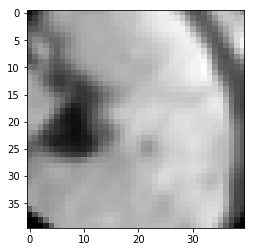

In [37]:
img = np.load("train_imgs\\cyst\\E100529980_1.npy")
#img = np.load("train_imgs\\cyst\\12302576_70.npy")
plt.imshow(img[:,:,5,0], cmap='gray')

In [3]:
def plot_section(img, df, pad=30):
    plt.subplot(121)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')
    plt.subplot(122)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 1], (1,0)), cmap='gray')

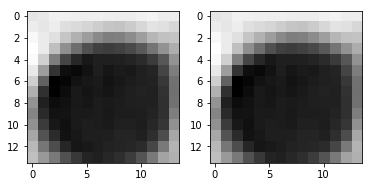

In [62]:
img_fn = "E100529980.npy"
img = np.load("full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=0)

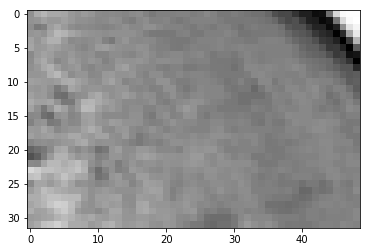

In [32]:
plt.imshow(cropped_imgs[0][:,:,5,0], cmap='gray')

In [106]:
img[:,:,:,1].shape

(280, 214, 79)